# Лабораторная работа №1. 

Цифровая обработка биомедицинских сигналов. Цифровые фильтры.

В этой лабораторной работе мы научимся анализировать и обрабатывать биомедицинские сигналы на примере ЭЭГ покоя, взятой из базы данных EEG Motor Movement/Imagery Dataset доступной на https://physionet.org/pn4/eegmmidb/



Импортируем библиотеки языка Python, необходимые нам для работы:

In [195]:
import numpy as np # NumPy - это пакет для фундаментальных математических расчетов. См. https://www.numpy.org
import matplotlib.pyplot as plt # Библиотека для вывода двумерных графиков. См. https://matplotlib.org
import mne # Билиотека для исследования и визуализации нейрофизиологических данных. См. https://www.nmr.mgh.harvard.edu/mne/stable/index.html
from scipy import signal, fftpack # Библиотека для математических и инженерных расчетов. См. https://scipy.org

# Разделы библиотеки MNE, предназначенные для считывания файлов из базы данных EEG Motor Movement/Imagery Dataset
from mne.datasets import eegbci # 
from mne.io import concatenate_raws, read_raw_edf #
from mne.viz import plot_filter, plot_ideal_filter

Загружаем на компьютер ЭЭГ покоя первого пациента:

In [196]:
subject = 1 # пациент № 1
runs = [1]  # номер эксперимента, содержащего ЭЭГ покоя

# Считывание файла в формате edf
fnames = eegbci.load_data(subject, runs)
raws = [read_raw_edf(f, preload=True, stim_channel='auto') for f in fnames]
raw = concatenate_raws(raws)
raw.rename_channels(lambda x: x.strip('.'))  # Переименование каналов для удаления лишней точки

Extracting EDF parameters from C:\Users\Home\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S001\S001R01.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Used Annotations descriptions: ['T0']


 В результате в переменную raw загружается объект типа raw: массив numpy с присоединенным к нему специальным объектом info. К данным объекта типа raw можно обеспечить доступ в соответствии с индексацией:

In [197]:
print(raw.info)

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, ...
    chs : list | 65 items (EEG: 64, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 80.0 Hz
    meas_date : tuple | 2009-08-12 16:15:00 GMT
    nchan : int | 65
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 160.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_l

Так, частоту дискретизации сигнала по времени можно узнать, обратившись к объекту raw следующим образом:

In [198]:
print('Частота дискретизации:', raw.info['sfreq'], 'Гц')

Частота дискретизации: 160.0 Гц


ЗАДАНИЕ 1: Вывести названия каналов ЭЭГ

In [199]:
# Вывод названий каналов ЭЭГ:


Выведем 10-секундную запись ЭЭГ с одного из каналов на график в интерактивном режиме. Используйте полосы вертикальной и горизонтальной прокрутки, чтобы перемещаться между каналами и интервалами записи.

In [200]:
# Инициализация интерактивного режима
%matplotlib 

raw.plot(duration=10.0, n_channels=1, block=True) # Задание числа одновременно выводимых каналов и интервалов времени
plt.show() # Вывод графика

Using matplotlib backend: Qt5Agg


Познакомимся с фильтрацией сигнала. 

Фильтрация может улучшись соотношение сигнал-шум и способствовать извлечению из сигнала нужной информации. В то же время, фильтрация может исказать исходный сигнал и привести к использованию неверной информации. Поэтому вопросы фильтрации нужно тщательно продумывать. 

Фильтры делятся на два типа: с конечной импульсной характеристикой (КИХ) и бесконечной импульсной характеристикой (БИХ). Импульсная характеристика - это реакция системы на единичный импульс. По сути, цифровой фильтр есть свертка входного сигнала с импульсной характеристикой, соответствующей желаемому фильтру. Свертка — это математическая операция, сводящаяся к интегрированию произведения двух функций. Амплитудно-частотная и импульсная характеристики связаны между собой преобразованием Фурье. Это значит, что мы можем нарисовать любую АЧХ на свой вкус, взять от нее обратное преобразование Фурье и получить импульсную характеристику. Полученная таким образом импульсная характеристика будет бесконечной. На ней основаны БИХ фильтры. Если ее обрезать в какой-то точке, исходная АЧХ исказится, на ней возникнут колебания, которые придется сглаживать дополнительными преобразованиями. Такую характеристику имеют КИХ фильтры.

У КИХ и БИХ фильтров свои преимущества: КИХ фильтры имеют одинаковую задержку на всех частотах (групповую задержку), а у БИХ фильтров круче спад частотной характеристики. КИХ фильтры также несколько проще и стабильнее, поэтому там, где нет необходимости в быстром и четком срезе частот, лучше использовать их.

Попробуем спроектировать КИХ фильтр нижних частот (пропускающий нижние и заваливающий высшие частоты). Пусть частота среза 30 Гц, т.е. до 30 Гц амплитуда сигнала равна 1, а после -60 дБ (пр. нулю). Тогда идеальная характеристика фильтра будет иметь вид:

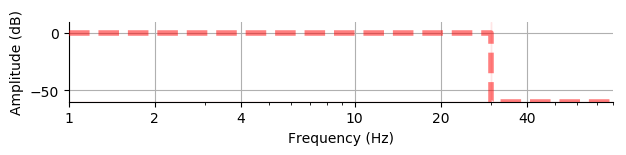

In [201]:
sfreq = 160. # частота дискретизации
f_p = 30.  # частота среза
flim = (1., sfreq / 2.)  # границы графика

nyq = sfreq / 2.  # частота Найквиста, равная половине частоты дискретизации
freq = [0, f_p, f_p, nyq]
gain = [1, 1, 0, 0]

third_height = np.array(plt.rcParams['figure.figsize']) * [1, 1. / 3.]
ax = plt.subplots(1, figsize=third_height)[1]
plot_ideal_filter(freq, gain, ax, title='Ideal %s Hz lowpass' % f_p, flim=flim)

Харакретистика, вроде бы, идеальная, все частоты после 40 Гц обрезаются полностью. Но следует помнить, что прямоугольное окно в частотной области отображается во временной области кардиальным синусом:

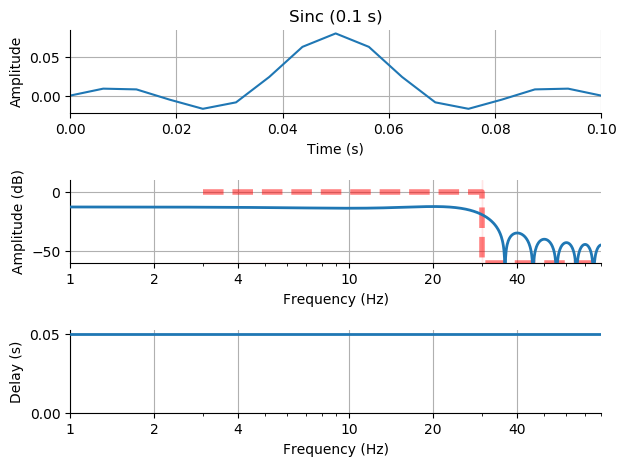

In [202]:
n = int(round(0.1 * sfreq))
t = np.arange(-(n // 2), n // 2 + 1) / sfreq 
h = np.sinc(2 * f_p * t) / (4 * np.pi)
plot_filter(h, sfreq, freq, gain, 'Sinc (0.1 s)', flim=flim)

Во временной области видны колебания в полосе отсечения, что уже не так хорошо. 

ЗАДАНИЕ 2. Увеличьте длительность переходного процесса в 10 раз и выведете характеристики фильтра. Должно быть видно, что подавление частот улучшилось, но колебания фильтра продолжаются в 10 раз дольше.

In [203]:
# Характеристики фильтра при длительности переходного процесса 1 с:


Если несколько ослабить требования к фильтру в частотной области, т.е. задать некую полосу частот, в которой будет постепенно происходить подавление сигнала, то получится следующее:

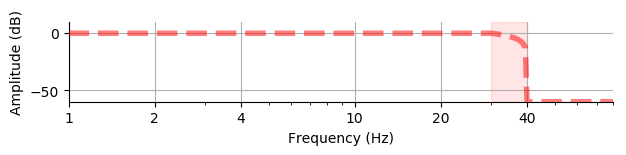

In [204]:
trans_bandwidth = 10  # Переходная область 10 Гц
f_s = f_p + trans_bandwidth  # = 40 Гц - частота, после которой сигнал ослабляется до -60 дБ

freq = [0., f_p, f_s, nyq]
gain = [1., 1., 0., 0.]
ax = plt.subplots(1, figsize=third_height)[1]
title = '%s Hz lowpass with a %s Hz transition' % (f_p, trans_bandwidth)
plot_ideal_filter(freq, gain, ax, title=title, flim=flim)

Используя более пологую характеристику в частотной области, удается добиться меньшего уровня колебаний во временной области

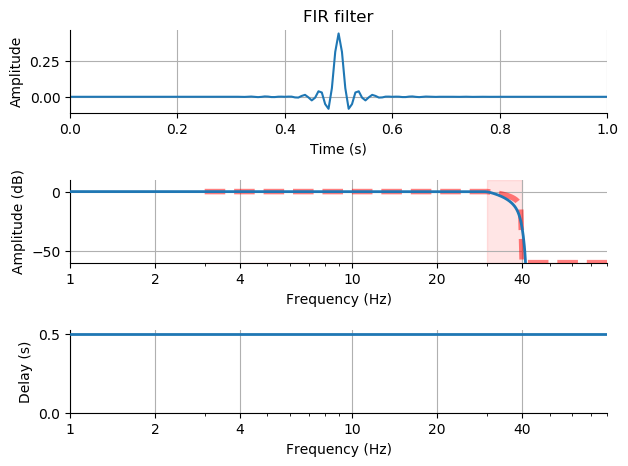

In [205]:
n = int(round(sfreq * 1.0)) + 1
h = signal.firwin2(n, freq, gain, nyq=nyq)
plot_filter(h, sfreq, freq, gain, flim=flim)

Среди БИХ фильтров наиболее известными являются фильтры Баттерворта, Чебышева и Бесселя. Фильтр Баттерворта имеет максимально плоскую характеристику в полосе пропускания.

Setting up low-pass filter at 30 Hz


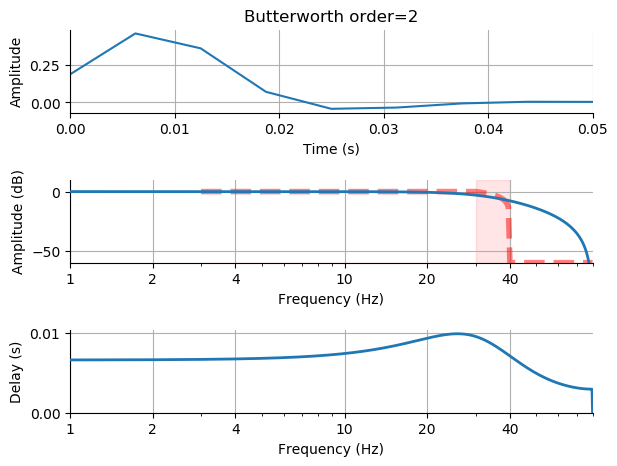

In [206]:
iir_params = dict(order=2, ftype='butter')
filt = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                                method='iir', iir_params=iir_params,
                                verbose=True)
plot_filter(filt, sfreq, freq, gain, 'Butterworth order=2', flim=flim)

ЗАДАНИЕ 3: Изменить порядок фильтра на 8 и сравнить характеристики фильтров. Какие выводы можно сделать?

In [207]:
# Фильтр Баттерворта восьмого порядка:


Применим фильтр Баттерворта 6 порядка и фильтр с конечной импульсной характеристикой с полосой пропускания 7-30 Гц к сигналу ЭЭГ с электрода C3:

In [239]:
# Выбираем канал для отображения
data = mne.pick_channels(raw.info["ch_names"], ["C3"]) 

# Строим график
data, times = raw[data, int(sfreq * 1):int(sfreq * 3)]
_ = plt.plot(times, data.T)

# Применяем фильтр Баттерворта 6 порядка:
iir_params = dict(order=6, ftype='butter')
Butt_6=mne.filter.filter_data(data, sfreq, 7, 30, method='iir', iir_params=iir_params, copy=True, verbose=None)
_ = plt.plot(times, Butt_6.T)

# КИХ фильтр:
Fir=mne.filter.filter_data(data, sfreq, 7, 30, fir_design='firwin')
_ = plt.plot(times, Fir.T)

Setting up band-pass filter from 7 - 30 Hz
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 265 samples (1.656 sec) selected


Из графиков видно, что изчезла постоянная составляющая. Сигнал центрирован относительно нуля. 

Остановимся на КИХ фильтре, как более стабильном и обеспечивающим достаточный уровень фильтрации.

Применим сконструированный фильтр ко всему массиву данных:

In [240]:
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 265 samples (1.656 sec) selected


<RawEDF  |  S001R01.edf, n_channels x n_times : 65 x 9760 (61.0 sec), ~5.0 MB, data loaded>

Теперь перестроим графики сигналов со всех электродов ЭЭГ:

In [241]:
raw.plot(duration=10.0, n_channels=1, block=True) # Задание числа одновременно выводимых каналов и интервалов времени
plt.show() # Вывод графика